In [11]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [12]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥1.0.2 is required
import sklearn
assert sklearn.__version__ >= "1.0.2"

# Common imports
import numpy as np
import os
import pandas as pd
import time

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update({'font.size': 20})
mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
mpl.rc('axes', labelsize=22)


# Load and process data

In [13]:
# read data from csv file
trainset = pd.read_csv('../datasets/dataset_MonteCarlo_100.000/trainset.csv')
testset = pd.read_csv('../datasets/dataset_MonteCarlo_100.000/testset.csv')
print(trainset.shape)
print(testset.shape)

(80000, 15)
(20000, 15)


In [14]:
trainset

,0_Ca,0_Cl,0_Na,0_K,0_N5,1_Ca,1_Cl,1_Na,1_K,1_N5,out_Ca,out_Cl,out_Na,out_K,out_N5
0,0.341575,1.159034,0.012636,0.451710,0.794808,0.347226,0.116634,0.755911,0.674340,1.359338,0.3233,1.1590,0.02901,0.4719,0.79480
1,0.638607,0.558054,1.231009,0.243433,1.132821,0.038278,0.185744,0.734268,1.464984,1.489907,0.4584,0.5581,1.24700,0.5882,1.13300
2,0.787981,0.763241,0.349968,0.738449,1.452716,1.117356,0.110285,0.393380,0.282715,1.466671,0.8053,0.7632,0.34980,0.7038,1.45300
3,0.466115,0.948450,0.942671,1.051085,1.358636,0.470234,0.252135,0.914662,1.318543,1.076570,0.4558,0.9484,0.94180,1.0730,1.35900
4,0.452663,0.644895,1.360873,0.991130,0.162887,1.361588,1.475943,0.637112,0.397679,1.414160,0.4939,0.6449,1.34300,0.9266,0.16290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,0.796601,0.398041,1.132371,0.996845,0.094560,1.074895,1.055513,0.777877,0.870241,0.361988,0.8083,0.3980,1.12600,0.9802,0.09456
79996,0.942419,1.456538,1.164360,0.775981,0.069458,1.024540,1.025283,0.144121,1.438743,0.241862,0.9305,1.4570,1.15000,0.8141,0.06946
79997,1.095302,0.438446,1.335379,0.365207,0.273701,0.765942,0.880543,1.152310,1.119219,1.104459,1.0670,0.4384,1.33500,0.4223,0.27370
79998,0.310626,0.661302,0.192742,1.280823,0.931653,0.199012,0.072267,0.870017,0.563615,0.006399,0.3275,0.6613,0.21380,1.2260,0.93170


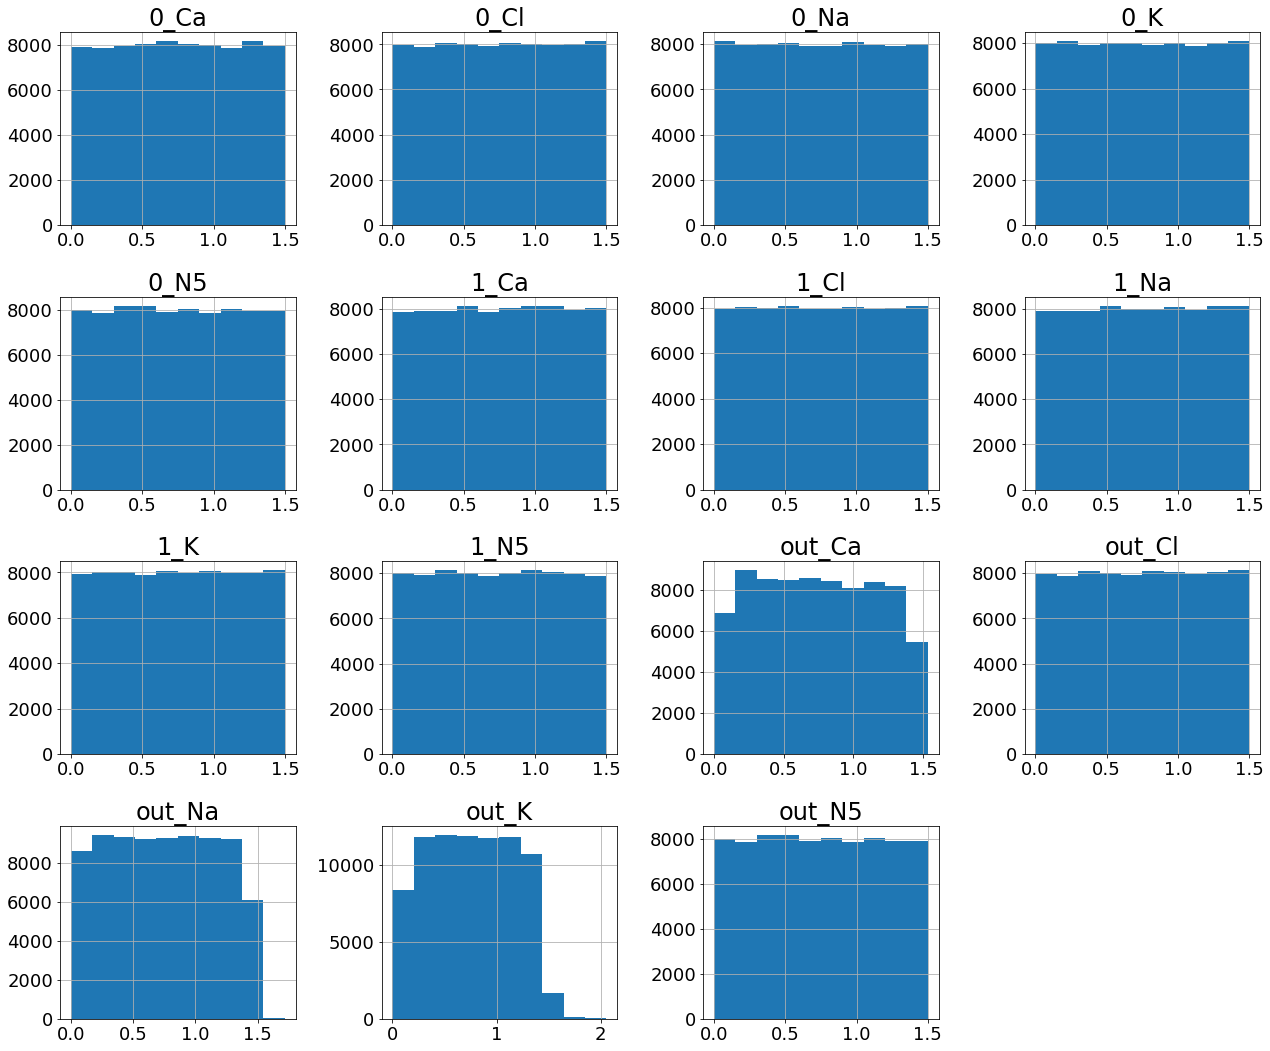

In [15]:
trainset.hist(figsize=(18, 15));
plt.tight_layout()

In [16]:
# split x and y
X_train = trainset.iloc[:, [0,2,3,5,7,8]].values 
y_train = trainset.iloc[:, [10, 12, 13]].values
X_test = testset.iloc[:, [0,2,3,5,7,8]].values 
y_test = testset.iloc[:, [10, 12, 13]].values

# Name variables
inputs = [list(trainset)[i] for i in [0,2,3,5,7,8]] 
outputs = [list(trainset)[i] for i in [10, 12, 13]] # do not work for list -> list(trainset)[10, 12, 13]

In [17]:
print('Inputs: ', inputs)
print('Outputs: ', outputs)
print('X_train instances: ', X_train.shape)
print('X_test instances: ', X_test.shape)
print('y_train instances: ', y_train.shape)
print('y_test instances: ', y_test.shape)

Inputs:  ['0_Ca', '0_Na', '0_K', '1_Ca', '1_Na', '1_K']
Outputs:  ['out_Ca', 'out_Na', 'out_K']
X_train instances:  (80000, 6)
X_test instances:  (20000, 6)
y_train instances:  (80000, 3)
y_test instances:  (20000, 3)


## Normalize data

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

norm_pipeline = Pipeline([
        ('minmax_scaler', MinMaxScaler((-1,1))),
    ])

X_train_norm = norm_pipeline.fit_transform(X_train)
X_test_norm = norm_pipeline.transform(X_test)

# Fine Tuning

## Tensorflow NN

In [19]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import RMSprop, Adam

print(tf.__version__)

2.4.1


In [20]:
mse = tf.keras.losses.MeanSquaredError()

# Constants
data_min_ = tf.constant(norm_pipeline['minmax_scaler'].data_min_, dtype=tf.float32)
data_max_ = tf.constant(norm_pipeline['minmax_scaler'].data_max_, dtype=tf.float32)
min_ = tf.constant(norm_pipeline['minmax_scaler'].feature_range[0], dtype=tf.float32)
max_ = tf.constant(norm_pipeline['minmax_scaler'].feature_range[1], dtype=tf.float32)

def pinn_loss(y_pred, x):

    # if data is scaled
    x_orig = ((x - min_) / (max_ - min_)) * (data_max_ - data_min_) + data_min_ 

    # Calculate the charge in the input and output
    charge_in = 2*x_orig[:, 0]+x_orig[:, 1]+x_orig[:, 2]
    charge_out = 2*y_pred[:, 0]+y_pred[:, 1]+y_pred[:, 2]

    return mse(charge_in, charge_out)  

2022-06-09 10:58:37.448193: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: Quadro RTX 4000 computeCapability: 7.5
coreClock: 1.545GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 387.49GiB/s
2022-06-09 10:58:37.448310: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-06-09 10:58:37.448345: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-06-09 10:58:37.448370: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2022-06-09 10:58:37.448395: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10
2022-06-09 10:58:37.448420: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcurand.so

In [21]:
# Losses metrics
loss_tracker = tf.keras.metrics.Mean(name="loss")
val_loss_tracker = tf.keras.metrics.Mean(name="loss")
mse_metric = tf.keras.metrics.MeanSquaredError(name="mse")
val_mse_metric = tf.keras.metrics.MeanSquaredError(name="mse")

class CustomModel(tf.keras.Model):
    
    def __init__(self, model, pinn_weight, **kwargs):
        super(CustomModel, self).__init__(**kwargs)
        self.model = model
        self.pinn_weight = pinn_weight
        
    
    def train_step(self, data):
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute our own loss
            loss = mse(y, y_pred) + pinn_loss(y_pred, x)*self.pinn_weight
            # Add any extra losses created during the forward pass.
            loss += sum(self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Compute our own metrics
        loss_tracker.update_state(loss)
        mse_metric.update_state(y, y_pred)
        # Return a dict mapping metric names to current value.
        return {"loss": loss_tracker.result(), "mse": mse_metric.result()}
    
    def test_step(self, data):
        # Unpack the data
        x, y = data
        # Compute predictions
        y_pred = self(x, training=False)
        # Updates the metrics tracking the loss
        loss = mse(y, y_pred) + pinn_loss(y_pred, x)*self.pinn_weight
        # Add any extra losses created during the forward pass.
        loss += sum(self.losses)
        # Update the metrics.
        val_loss_tracker.update_state(loss)
        val_mse_metric.update_state(y, y_pred)
        # Return a dict mapping metric names to current value.
        return {"loss": val_loss_tracker.result(), "mse": val_mse_metric.result()}
    
    # implement the call method
    def call(self, inputs, *args, **kwargs):
        return self.model(inputs) 

    @property
    def metrics(self):
        # We list our `Metric` objects here so that `reset_states()` can be
        # called automatically at the start of each epoch
        # or at the start of `evaluate()`.
        # If you don't implement this property, you have to call
        # `reset_states()` yourself at the time of your choosing.
        return [loss_tracker, mse_metric, val_loss_tracker, val_mse_metric]

cusparse.so.10
2022-06-09 10:58:37.448492: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-06-09 10:58:37.451362: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1862] Adding visible gpu devices: 0
2022-06-09 10:58:38.009314: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1261] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-06-09 10:58:38.009384: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1267]      0 
2022-06-09 10:58:38.009391: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1280] 0:   N 
2022-06-09 10:58:38.011184: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1406] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 6451 MB memory) -> physical GPU (device: 0, name: Quadro RTX 4000, pci bus id: 0000:21:00.0, compute capability: 7.5)
2022-06-09 10:58:38.011591: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enab

In [22]:
INPUT_SIZE = 6
OUTPUT_SIZE = 3 

# Model
def create_model(hiden_layers, neurons, dropout, kreg, activation, lactivation, lr, pinn_weight):
    model = Sequential()
    model.add(Dense(neurons, input_shape=(INPUT_SIZE,), activation=activation, kernel_regularizer=l2(kreg)))
    if dropout >1e-3:
        model.add(Dropout(dropout))
    for i in range(hiden_layers):
        model.add(Dense(neurons, activation=activation, kernel_regularizer=l2(kreg)))
        if dropout >1e-3:
            model.add(Dropout(dropout))
    model.add(Dense(OUTPUT_SIZE, activation=lactivation))
    
    custom_model = CustomModel(model, pinn_weight)

    custom_model.compile(optimizer= Adam(lr))
                  
    return custom_model

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                               min_delta=0.0,
                                               patience=10,
                                               verbose=1,
                                               restore_best_weights=True)

In [23]:
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'hiden_layers': [1, 2],
     'batch_size': [128], 
     'neurons': [64, 128, 256], 
     'dropout': [0.0],
     'kreg': [1e-6, 1e-4],
     'activation': ['relu'], 
     'lactivation': ['linear'], #['linear','tanh'],
     'lr': [1e-4],   
     'pinn_weight': [0.1,0.5,1.0,5.0]
    }]
    
model = KerasRegressor(build_fn=create_model,  epochs=300, verbose=0)

grid_search = GridSearchCV(estimator=model, 
                           param_grid=param_grid, 
                           cv=3,
                           scoring='neg_mean_squared_error',
                           return_train_score=True, 
                           verbose = 1,
                           n_jobs= 1)
start = time.time()
grid_search.fit(X_train_norm, y_train, callbacks = [early_stopping])
print("Run time = ", time.time()-start)

2022-06-09 10:58:38.209628: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Fitting 3 folds for each of 48 candidates, totalling 144 fits


2022-06-09 10:58:38.229681: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2349850000 Hz
2022-06-09 10:58:38.654045: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


Restoring model weights from the end of the best epoch.
Epoch 00294: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00241: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00238: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00237: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00272: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00259: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00254: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00296: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00233: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00224: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00233: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00261: early s

In [24]:
print(f"best parameters: {grid_search.best_params_}")
print(f"best score:      {-grid_search.best_score_:0.5f} (+/-{grid_search.cv_results_['std_test_score'][grid_search.best_index_]:0.5f})")
 

best parameters: {'activation': 'relu', 'batch_size': 128, 'dropout': 0.0, 'hiden_layers': 1, 'kreg': 1e-06, 'lactivation': 'linear', 'lr': 0.0001, 'neurons': 128, 'pinn_weight': 1.0}
best score:      0.00003 (+/-0.00001)


In [25]:
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

,params,rank_test_score,mean_test_score,std_test_score
6,"{'activation': 'relu', 'batch_size': 128, 'dro...",1,-0.000032,0.000007
25,"{'activation': 'relu', 'batch_size': 128, 'dro...",2,-0.000033,0.000004
8,"{'activation': 'relu', 'batch_size': 128, 'dro...",3,-0.000034,0.000003
10,"{'activation': 'relu', 'batch_size': 128, 'dro...",4,-0.000034,0.000004
24,"{'activation': 'relu', 'batch_size': 128, 'dro...",5,-0.000034,0.000003
30,"{'activation': 'relu', 'batch_size': 128, 'dro...",6,-0.000035,0.000003
0,"{'activation': 'relu', 'batch_size': 128, 'dro...",7,-0.000036,0.000006
9,"{'activation': 'relu', 'batch_size': 128, 'dro...",8,-0.000036,0.000008
5,"{'activation': 'relu', 'batch_size': 128, 'dro...",9,-0.000036,0.000002
2,"{'activation': 'relu', 'batch_size': 128, 'dro...",10,-0.000036,0.000004


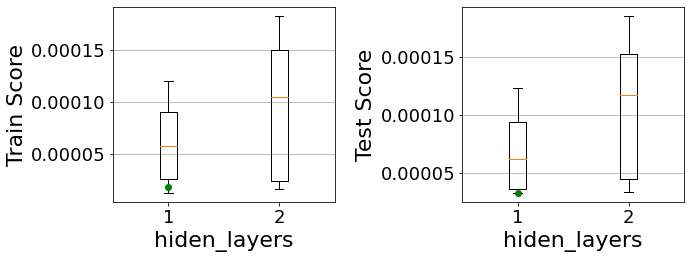

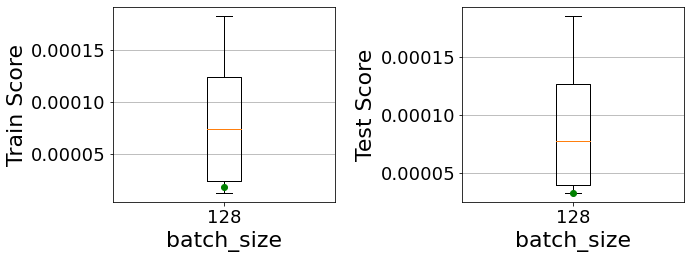

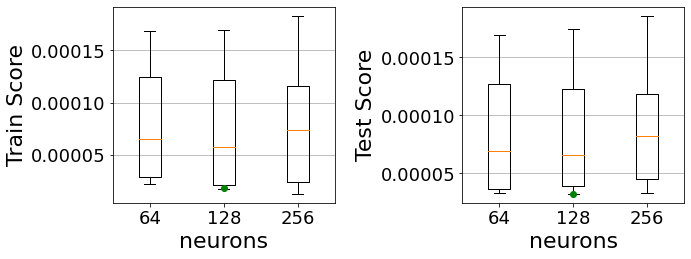

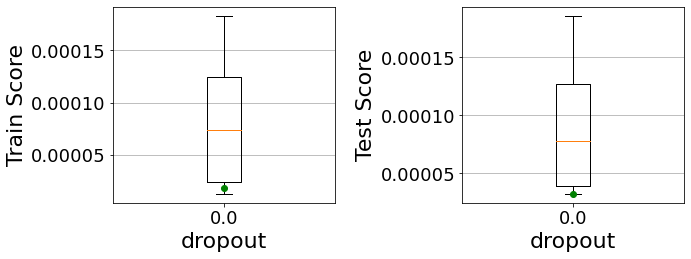

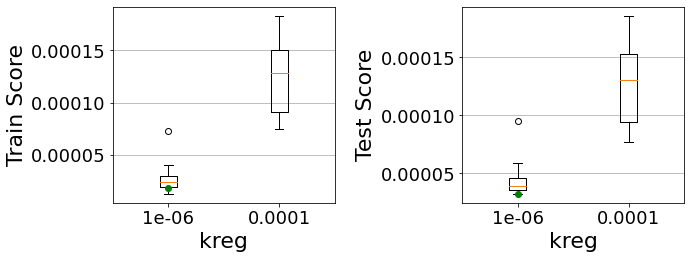

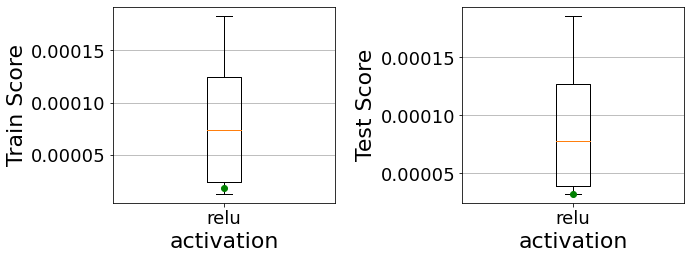

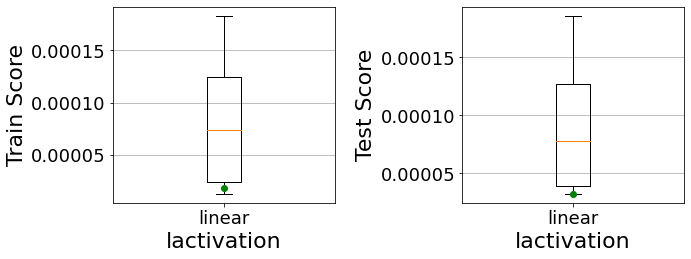

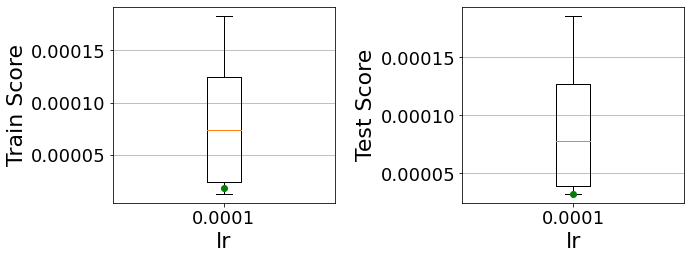

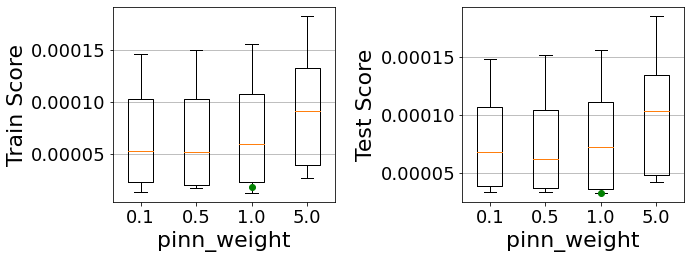

In [26]:
for param_name in param_grid[0]:

    params = sorted(results_df['param_' + param_name].unique())
    means_train = [-results_df[results_df['param_' + param_name] == p]['mean_train_score'] for p in params]
    means_test = [-results_df[results_df['param_' + param_name] == p]['mean_test_score'] for p in params]

    # plot
    fig, axes = plt.subplots(1,2, figsize=(10,4))

    axes[0].boxplot(means_train)
    axes[0].plot(params.index(grid_search.best_params_[param_name])+1,
                 -grid_search.cv_results_['mean_train_score'][grid_search.best_index_], 'go')
    axes[0].set_xlabel(param_name)
    axes[0].set_ylabel('Train Score')
    
    axes[1].boxplot(means_test)
    axes[1].plot(params.index(grid_search.best_params_[param_name])+1,
                 -grid_search.cv_results_['mean_test_score'][grid_search.best_index_], 'go')    
    axes[1].set_xlabel(param_name)
    axes[1].set_ylabel('Test Score')
    
    # adding horizontal grid lines
    for ax in axes:
        ax.yaxis.grid(True)
        ax.set_xticks([x+1 for x in range(len(params))], labels=list(map(str, params)))
    
    plt.tight_layout()
    plt.show()

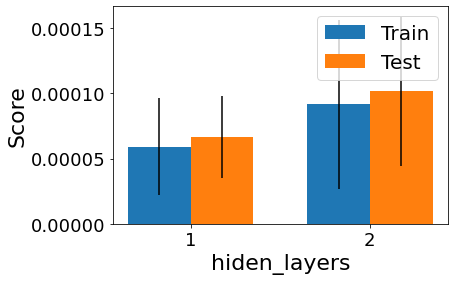

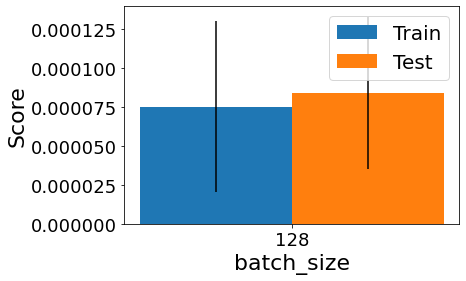

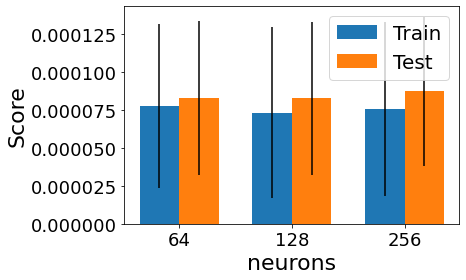

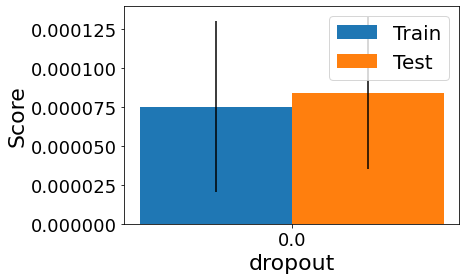

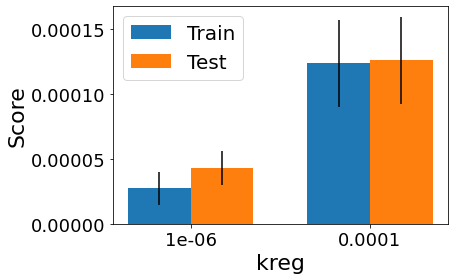

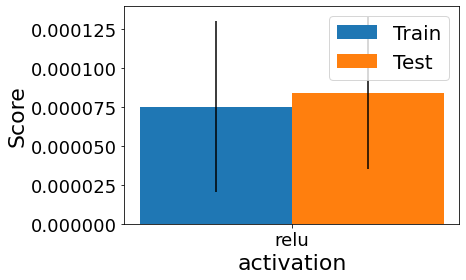

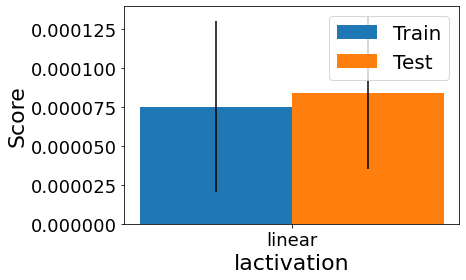

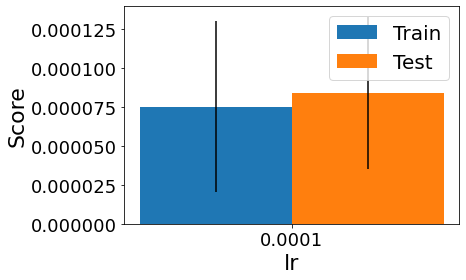

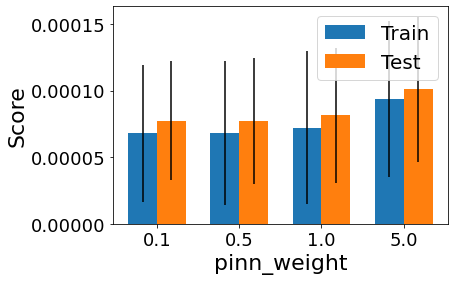

In [27]:
for param_name in param_grid[0]:
    
    results_dfg = results_df.groupby('param_' + param_name)
    params = results_dfg.groups.keys() # or params = results_df['param_' + param_name].unique()
    means_train = -results_dfg.mean()['mean_train_score']
    stds_train = results_dfg.std()['mean_train_score']
    means_test = -results_dfg.mean()['mean_test_score']
    stds_test = results_dfg.std()['mean_test_score']

    # plot
    fig, ax = plt.subplots()
    
    x = np.arange(len(params))  # the label locations
    width = 0.35  # the width of the bars

    ax.bar(x - width/2, means_train, width, yerr=stds_train, label = 'Train')
    ax.bar(x + width/2, means_test, width, yerr=stds_test, label = 'Test')
    ax.set_xticks(x, list(map(str, params)))
    ax.set_xlabel(param_name)
    ax.set_ylabel('Score')
    ax.legend()
    plt.show()

In [28]:
reg_best = grid_search.best_estimator_

print(grid_search.best_params_, end='\n')
print(grid_search.best_estimator_)

{'activation': 'relu', 'batch_size': 128, 'dropout': 0.0, 'hiden_layers': 1, 'kreg': 1e-06, 'lactivation': 'linear', 'lr': 0.0001, 'neurons': 128, 'pinn_weight': 1.0}


In [29]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.0059687652734222475 {'activation': 'relu', 'batch_size': 128, 'dropout': 0.0, 'hiden_layers': 1, 'kreg': 1e-06, 'lactivation': 'linear', 'lr': 0.0001, 'neurons': 64, 'pinn_weight': 0.1}
0.006059240136181065 {'activation': 'relu', 'batch_size': 128, 'dropout': 0.0, 'hiden_layers': 1, 'kreg': 1e-06, 'lactivation': 'linear', 'lr': 0.0001, 'neurons': 64, 'pinn_weight': 0.5}
0.00601409614056267 {'activation': 'relu', 'batch_size': 128, 'dropout': 0.0, 'hiden_layers': 1, 'kreg': 1e-06, 'lactivation': 'linear', 'lr': 0.0001, 'neurons': 64, 'pinn_weight': 1.0}
0.006615279767333293 {'activation': 'relu', 'batch_size': 128, 'dropout': 0.0, 'hiden_layers': 1, 'kreg': 1e-06, 'lactivation': 'linear', 'lr': 0.0001, 'neurons': 64, 'pinn_weight': 5.0}
0.006300201606218656 {'activation': 'relu', 'batch_size': 128, 'dropout': 0.0, 'hiden_layers': 1, 'kreg': 1e-06, 'lactivation': 'linear', 'lr': 0.0001, 'neurons': 128, 'pinn_weight': 0.1}
0.006009772425628002 {'activation': 'relu', 'batch_size': 128, '

In [30]:
sorted(zip(np.sqrt(-cvres["mean_test_score"]), cvres["params"]), key=lambda cvres: cvres[0], reverse=False)

[(0.005691918279307528,
  {'activation': 'relu',
   'batch_size': 128,
   'dropout': 0.0,
   'hiden_layers': 1,
   'kreg': 1e-06,
   'lactivation': 'linear',
   'lr': 0.0001,
   'neurons': 128,
   'pinn_weight': 1.0}),
 (0.005735119617674479,
  {'activation': 'relu',
   'batch_size': 128,
   'dropout': 0.0,
   'hiden_layers': 2,
   'kreg': 1e-06,
   'lactivation': 'linear',
   'lr': 0.0001,
   'neurons': 64,
   'pinn_weight': 0.5}),
 (0.00579254005779793,
  {'activation': 'relu',
   'batch_size': 128,
   'dropout': 0.0,
   'hiden_layers': 1,
   'kreg': 1e-06,
   'lactivation': 'linear',
   'lr': 0.0001,
   'neurons': 256,
   'pinn_weight': 0.1}),
 (0.00582380591953051,
  {'activation': 'relu',
   'batch_size': 128,
   'dropout': 0.0,
   'hiden_layers': 1,
   'kreg': 1e-06,
   'lactivation': 'linear',
   'lr': 0.0001,
   'neurons': 256,
   'pinn_weight': 1.0}),
 (0.005839220890232097,
  {'activation': 'relu',
   'batch_size': 128,
   'dropout': 0.0,
   'hiden_layers': 2,
   'kreg': 1e-0

In [31]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

start = time.time()
y_train_pred = reg_best.predict(X_train_norm)
end = time.time()
print("time = ", start - end)
print()

mse = mean_squared_error(y_train, y_train_pred)
print('mse: ',mse)
rmse = np.sqrt(mse)
print('rmse: ',rmse)
mae = mean_absolute_error(y_train, y_train_pred)
print('mae: ',mae)

r2_model = r2_score(y_train, y_train_pred)
print('\nR2: ',r2_model)

time =  -0.35222911834716797

mse:  1.6958862512499664e-05
rmse:  0.004118113950888157
mae:  0.0014473096257362165

R2:  0.9999010459129893


In [32]:
start = time.time()
y_test_pred = reg_best.predict(X_test_norm)
end = time.time()
print("time = ", start - end)
print()

mse = mean_squared_error(y_test, y_test_pred)
print('mse: ',mse)
rmse = np.sqrt(mse)
print('rmse: ',rmse)
mae = mean_absolute_error(y_test, y_test_pred)
print('mae: ',mae)

r2_model = r2_score(y_test, y_test_pred)
print('\nR2: ',r2_model)

time =  -0.15977740287780762

mse:  2.5444267355637733e-05
rmse:  0.005044231096573365
mae:  0.0015276576551396797

R2:  0.9998497098440832


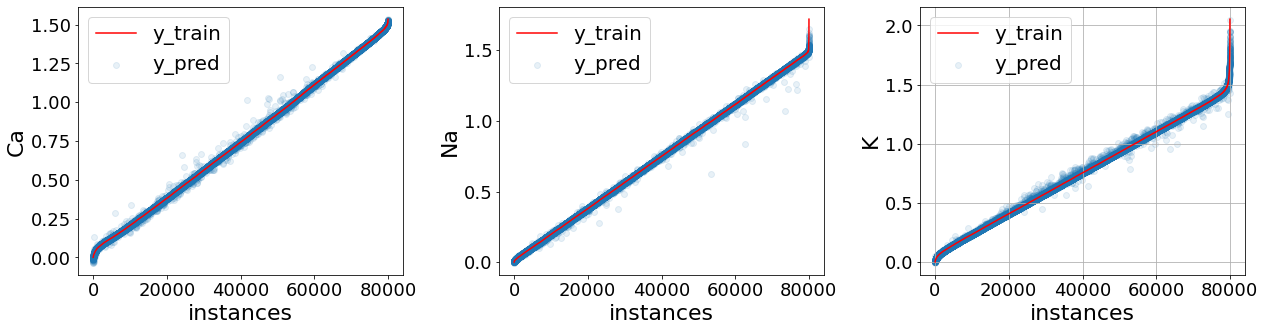

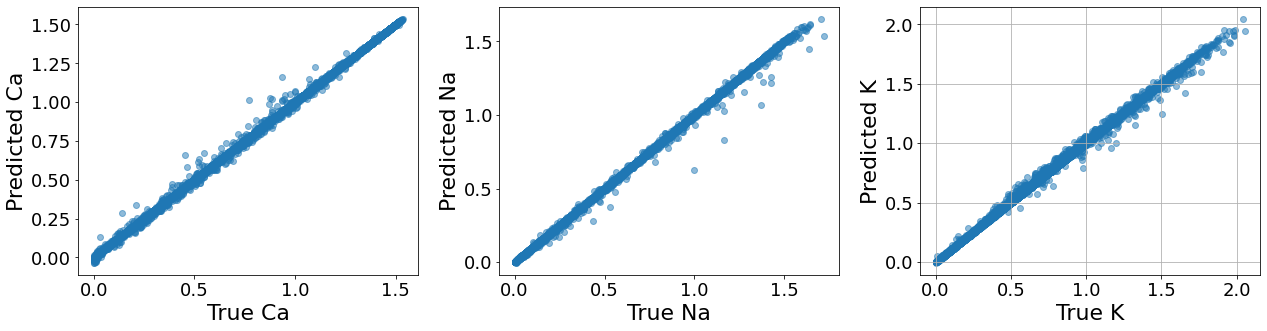

In [33]:
mpl.rcParams.update({'font.size': 20})
mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
mpl.rc('axes', labelsize=22)
fig, axes = plt.subplots(1,3, figsize=[18,5])

for i, ax in enumerate(axes.flat):
    aux_train = y_train[:,i]
    aux_pred = y_train_pred[:,i]
    index = np.argsort(aux_train)
    x = range(len(index))
    ax.plot(x, aux_train[index], 'r-')
    ax.scatter(x, aux_pred[index], alpha=0.1)
    ax.legend(['y_train', 'y_pred'])
    ax.set_xlabel('instances')
    ax.set_ylabel(outputs[i].split('_')[1])
    plt.grid()
plt.tight_layout()

print('\n\n')

fig, axes = plt.subplots(1,3, figsize=[18,5])

for i, ax in enumerate(axes.flat):
    ax.scatter(y_train[:,i], y_train_pred[:,i], alpha=0.5)
    ax.set_xlabel('True '+outputs[i].split('_')[1])
    ax.set_ylabel('Predicted '+outputs[i].split('_')[1])
    plt.grid()
plt.tight_layout()

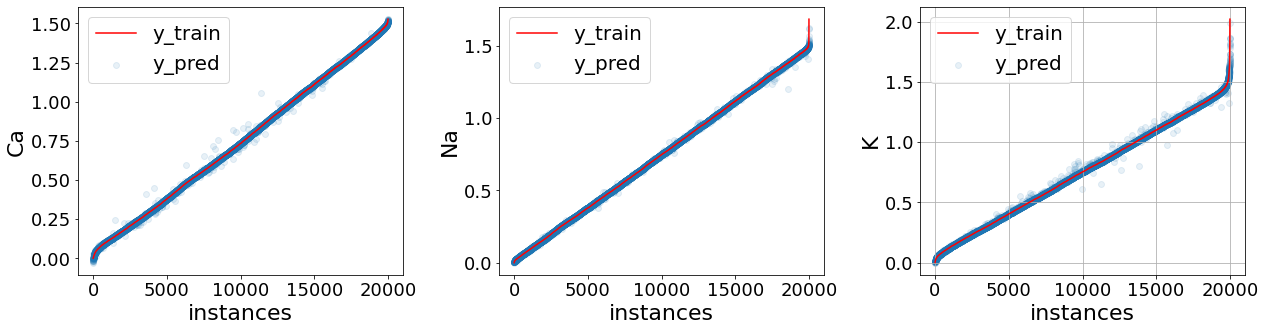

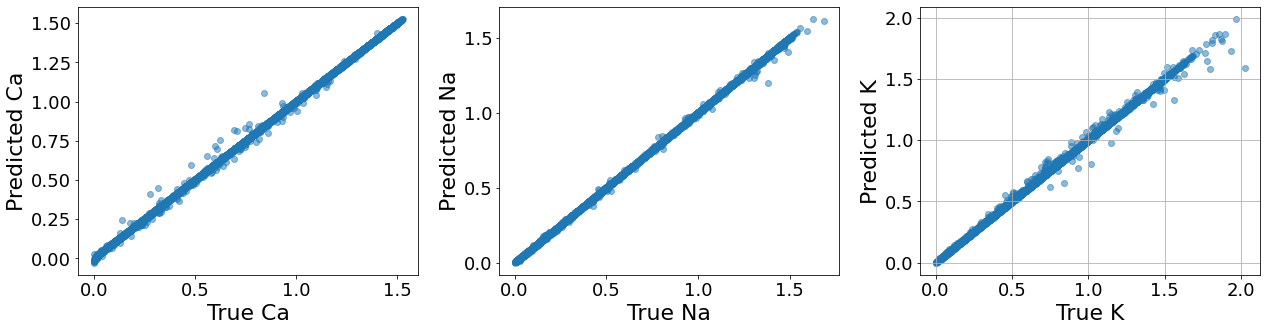

In [34]:
mpl.rcParams.update({'font.size': 20})
mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
mpl.rc('axes', labelsize=22)
fig, axes = plt.subplots(1,3, figsize=[18,5])

for i, ax in enumerate(axes.flat):
    aux_train = y_test[:,i]
    aux_pred = y_test_pred[:,i]
    index = np.argsort(aux_train)
    x = range(len(index))
    ax.plot(x, aux_train[index], 'r-')
    ax.scatter(x, aux_pred[index], alpha=0.1)
    ax.legend(['y_train', 'y_pred'])
    ax.set_xlabel('instances')
    ax.set_ylabel(outputs[i].split('_')[1])
    plt.grid()
plt.tight_layout()

print('\n\n')

fig, axes = plt.subplots(1,3, figsize=[18,5])

for i, ax in enumerate(axes.flat):
    ax.scatter(y_test[:,i], y_test_pred[:,i], alpha=0.5)
    ax.set_xlabel('True '+outputs[i].split('_')[1])
    ax.set_ylabel('Predicted '+outputs[i].split('_')[1])
    plt.grid()
plt.tight_layout()

## Checking charge constraint

In [35]:
charge_in = 2*X_train[:, 0]+X_train[:, 1]+X_train[:, 2]
charge_out = 2*y_train_pred[:, 0]+y_train_pred[:, 1]+y_train_pred[:, 2]

mean_absolute_error(charge_in, charge_out)  

0.000926581325488729

In [36]:
charge_in = 2*X_test[:, 0]+X_test[:, 1]+X_test[:, 2]
charge_out = 2*y_test_pred[:, 0]+y_test_pred[:, 1]+y_test_pred[:, 2]

mean_absolute_error(charge_in, charge_out)  

0.0009364420997335501

## Model persistence

In [38]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from tensorflow.keras.models import load_model
reg_best.model.save("NNmodel-pinn.tf", save_format="tf")
NNmodel_loaded = load_model("NNmodel-pinn.tf") 

import joblib
#joblib.dump(norm_pipeline, "norm_pipeline.pkl") 
#joblib.dump(ynorm_pipeline, "ynorm_pipeline.pkl") 
norm_pipeline_loaded = joblib.load("norm_pipeline.pkl")
#ynorm_pipeline_loaded = joblib.load("ynorm_pipeline.pkl")

print('rmse: ', np.sqrt(mean_squared_error(y_test,
                NNmodel_loaded.predict(norm_pipeline_loaded.transform(X_test)))))

2022-06-09 21:43:54.918249: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: NNmodel-pinn.tf/assets
rmse:  0.005044231096573365


In [42]:
# Add Physics-constrained

y_test_pred = NNmodel_loaded.predict(norm_pipeline_loaded.transform(X_test))
y_test_pred = (y_test_pred.T*(2*X_test[:, 0]+X_test[:, 1]+X_test[:, 2]) \
                         /(2*y_test_pred[:, 0]+y_test_pred[:, 1]+y_test_pred[:, 2])).T
print('rmse: ', np.sqrt(mean_squared_error(y_test, y_test_pred)))

rmse:  0.0050428617615730364
